In [84]:
# Imports
import warnings
import pickle
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Our module
from utils import eda, feat_eng, data_prep

In [85]:
# Notebook and pandas dataframe output arrangements
warnings.simplefilter(action="ignore")
pd.set_option("display.width",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.rcParams["figure.figsize"] = (8,3)

In [86]:
# Loading data
df = eda.load_data("./data.csv")

# EDA

## Big Picture

In [87]:
# Observing first 5 records
df.head()

,type,boat_class,year,condition,length_ft,beam_ft,hull_material,fuel_type,num_engines,total_hp,price
1,power,power-center,1992,used,21.000,8.500,fiberglass,gasoline,1,150.000,16500.000
3,power,power-sportcruiser,2018,used,40.000,11.000,fiberglass,diesel,2,800.000,539000.000
5,power,power-deck,2020,new,18.000,7.420,fiberglass,gasoline,1,75.000,26995.000
6,power,power-expresscruiser,2015,used,32.000,10.330,fiberglass,gasoline,2,600.000,169995.000
8,power,power-aft,1994,used,44.000,15.000,fiberglass,diesel,2,700.000,109900.000


In [88]:
# 18903 rows, 11 columns
df.shape

(18903, 11)

In [89]:
# Showing columns
df.columns

Index(['type', 'boat_class', 'year', 'condition', 'length_ft', 'beam_ft', 'hull_material', 'fuel_type', 'num_engines', 'total_hp', 'price'], dtype='object')

In [90]:
# Showing their dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18903 entries, 1 to 20000
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           18903 non-null  object 
 1   boat_class     18903 non-null  object 
 2   year           18903 non-null  int64  
 3   condition      18903 non-null  object 
 4   length_ft      18903 non-null  float64
 5   beam_ft        12399 non-null  float64
 6   hull_material  18903 non-null  object 
 7   fuel_type      15951 non-null  object 
 8   num_engines    18903 non-null  int64  
 9   total_hp       18055 non-null  float64
 10  price          18903 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.7+ MB


In [91]:
# Descriptive statistics 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,18903.000,2013.146,10.503,1910.000,2011.000,2019.000,2019.000,2020.000
length_ft,18903.000,23.804,14.613,1.000,18.000,21.000,25.000,375.000
beam_ft,12399.000,16.197,36.834,0.080,7.830,8.500,9.000,1311.000
num_engines,18903.000,1.070,0.426,0.000,1.000,1.000,1.000,4.000
total_hp,18055.000,112.849,286.138,0.000,0.000,0.000,115.000,7200.000
price,18903.000,647146.881,73095667.967,500.000,19255.000,34195.000,57830.000,9999999999.000


In [92]:
# Grabbing numeric and categoric columns and showing the summary
num_cols, cat_cols = eda.grab_cols(df,True)

************************* SUMMARY **************************
# of categoric variables: 5
['type', 'boat_class', 'condition', 'hull_material', 'fuel_type']
# of numeric variables: 6
['year', 'length_ft', 'beam_ft', 'num_engines', 'total_hp', 'price']


## Categoric Variables

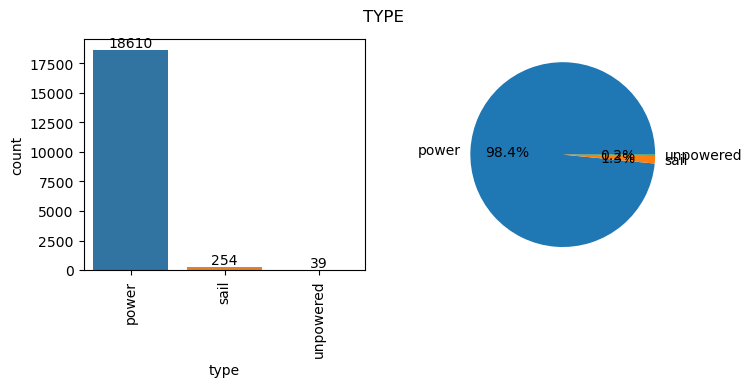

type
power       655864.624
sail        107258.261
unpowered     3416.254
Name: price, dtype: float64


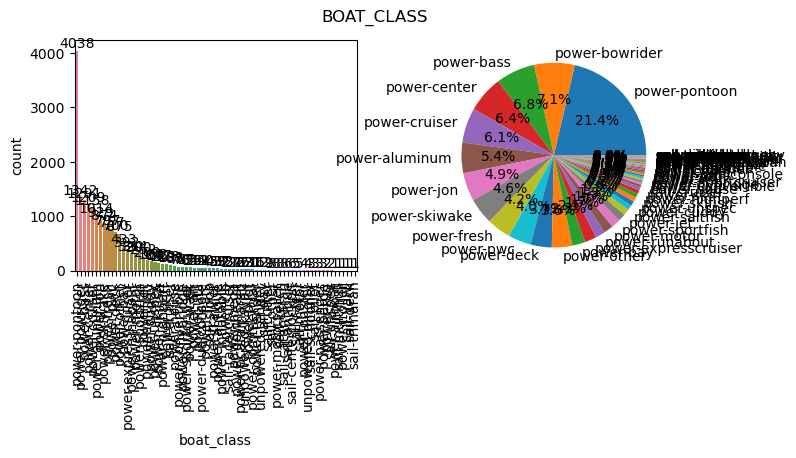

boat_class
power-aft            74831.286
power-airboat       139889.000
power-aluminum       26790.278
power-antique        92108.256
power-barge        3691633.333
                       ...    
sail-unspec          37249.500
sail-yawl            99500.000
unpowered-dinghy      3520.000
unpowered-kayak       1956.474
unpowered-tender      6179.583
Name: price, Length: 72, dtype: float64


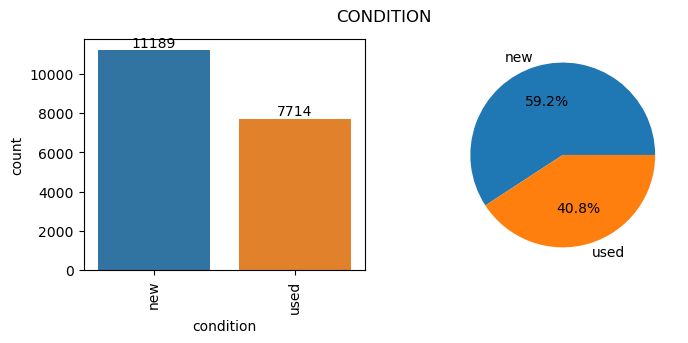

condition
new    1033893.184
used     86179.240
Name: price, dtype: float64


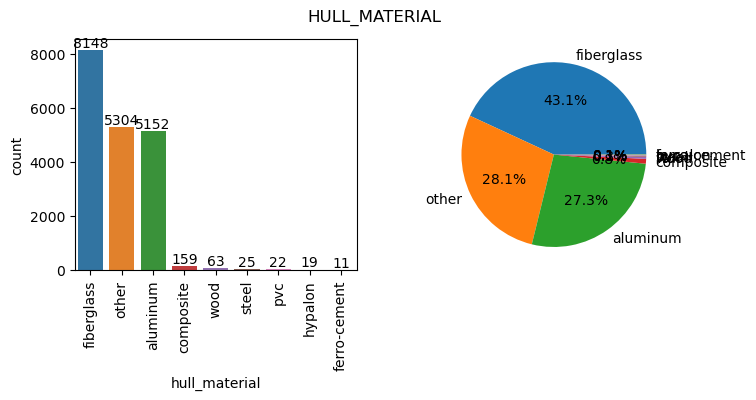

hull_material
aluminum          33703.115
composite      69445103.581
ferro-cement      27334.091
fiberglass        95316.701
hypalon           31693.842
other             39516.191
pvc                6587.182
steel            914488.920
wood             118463.746
Name: price, dtype: float64


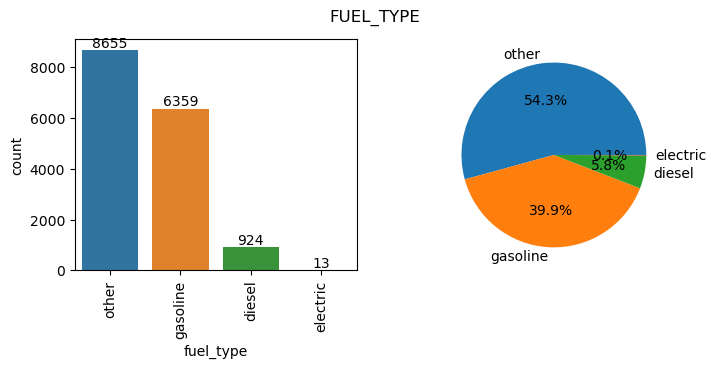

fuel_type
diesel      391092.310
electric     72989.769
gasoline   1788027.215
other        48255.354
Name: price, dtype: float64


In [93]:
# Plotting categoric variables to observe their distributions
for col in cat_cols:
    eda.cat_summary(df,col)

## Numeric Variables

In [94]:
# Taking sample due to excessively high response time for plotting numeric variables on full dataset
df_samp = df.sample(2000)

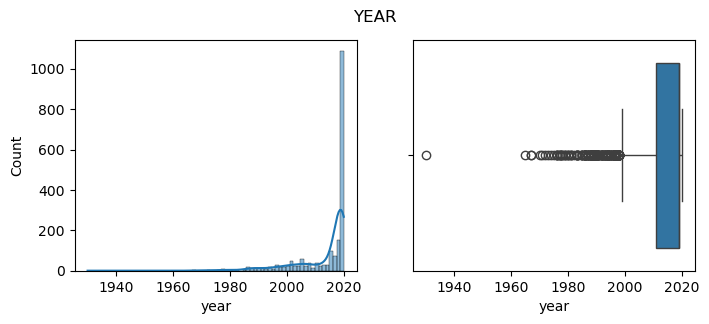

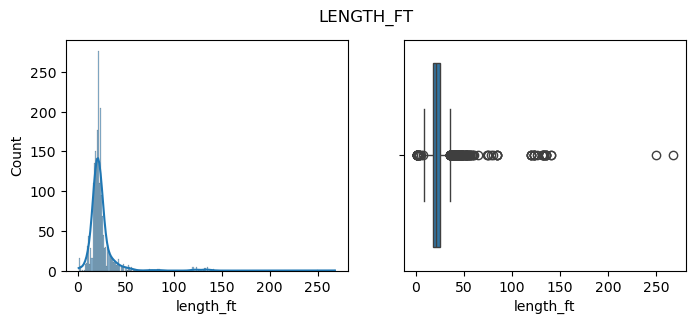

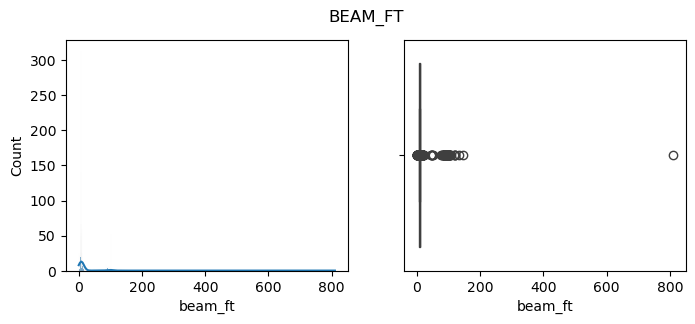

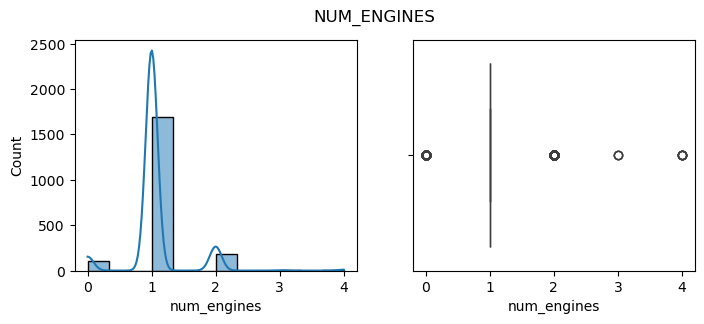

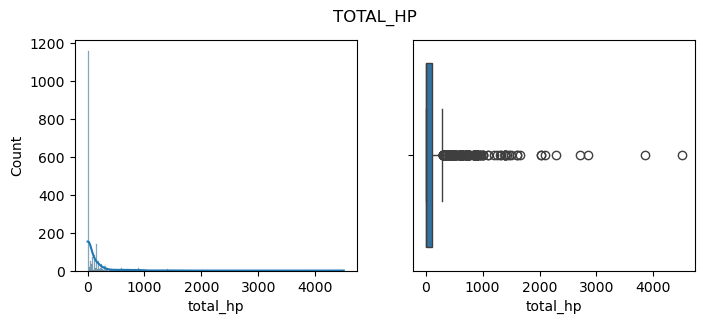

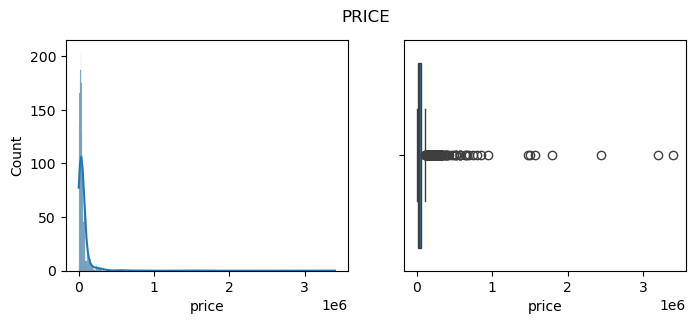

In [95]:
# Plotting numeric variables to observe their distributions and outliers
for col in num_cols:
    eda.num_summary(df_samp,col)

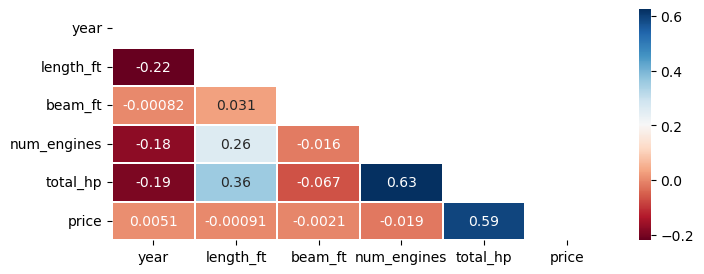

In [96]:
# Correlation plot
eda.corr_analysis(df,num_cols)

# Data Preprocessing

## Duplicated records

In [97]:
# Observing duplicated records
df[df.duplicated(keep=False)].sort_values(by="price")

,type,boat_class,year,condition,length_ft,beam_ft,hull_material,fuel_type,num_engines,total_hp,price
12957,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10581,power,power-jon,2016,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10578,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10574,power,power-jon,2016,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10085,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
...,...,...,...,...,...,...,...,...,...,...,...
62,power,power-mega,2019,new,48.000,NaN,fiberglass,diesel,2,870.000,799000.000
50,power,power-mega,2019,new,50.000,NaN,fiberglass,diesel,2,1340.000,1099000.000
49,power,power-mega,2019,new,50.000,NaN,fiberglass,diesel,2,1340.000,1099000.000
54,power,power-mega,2019,new,51.000,NaN,fiberglass,diesel,2,1340.000,1225000.000


In [98]:
# Dropping them
df.drop_duplicates(inplace=True)

In [99]:
# Checking
df.duplicated().sum()

0

## Missing Values

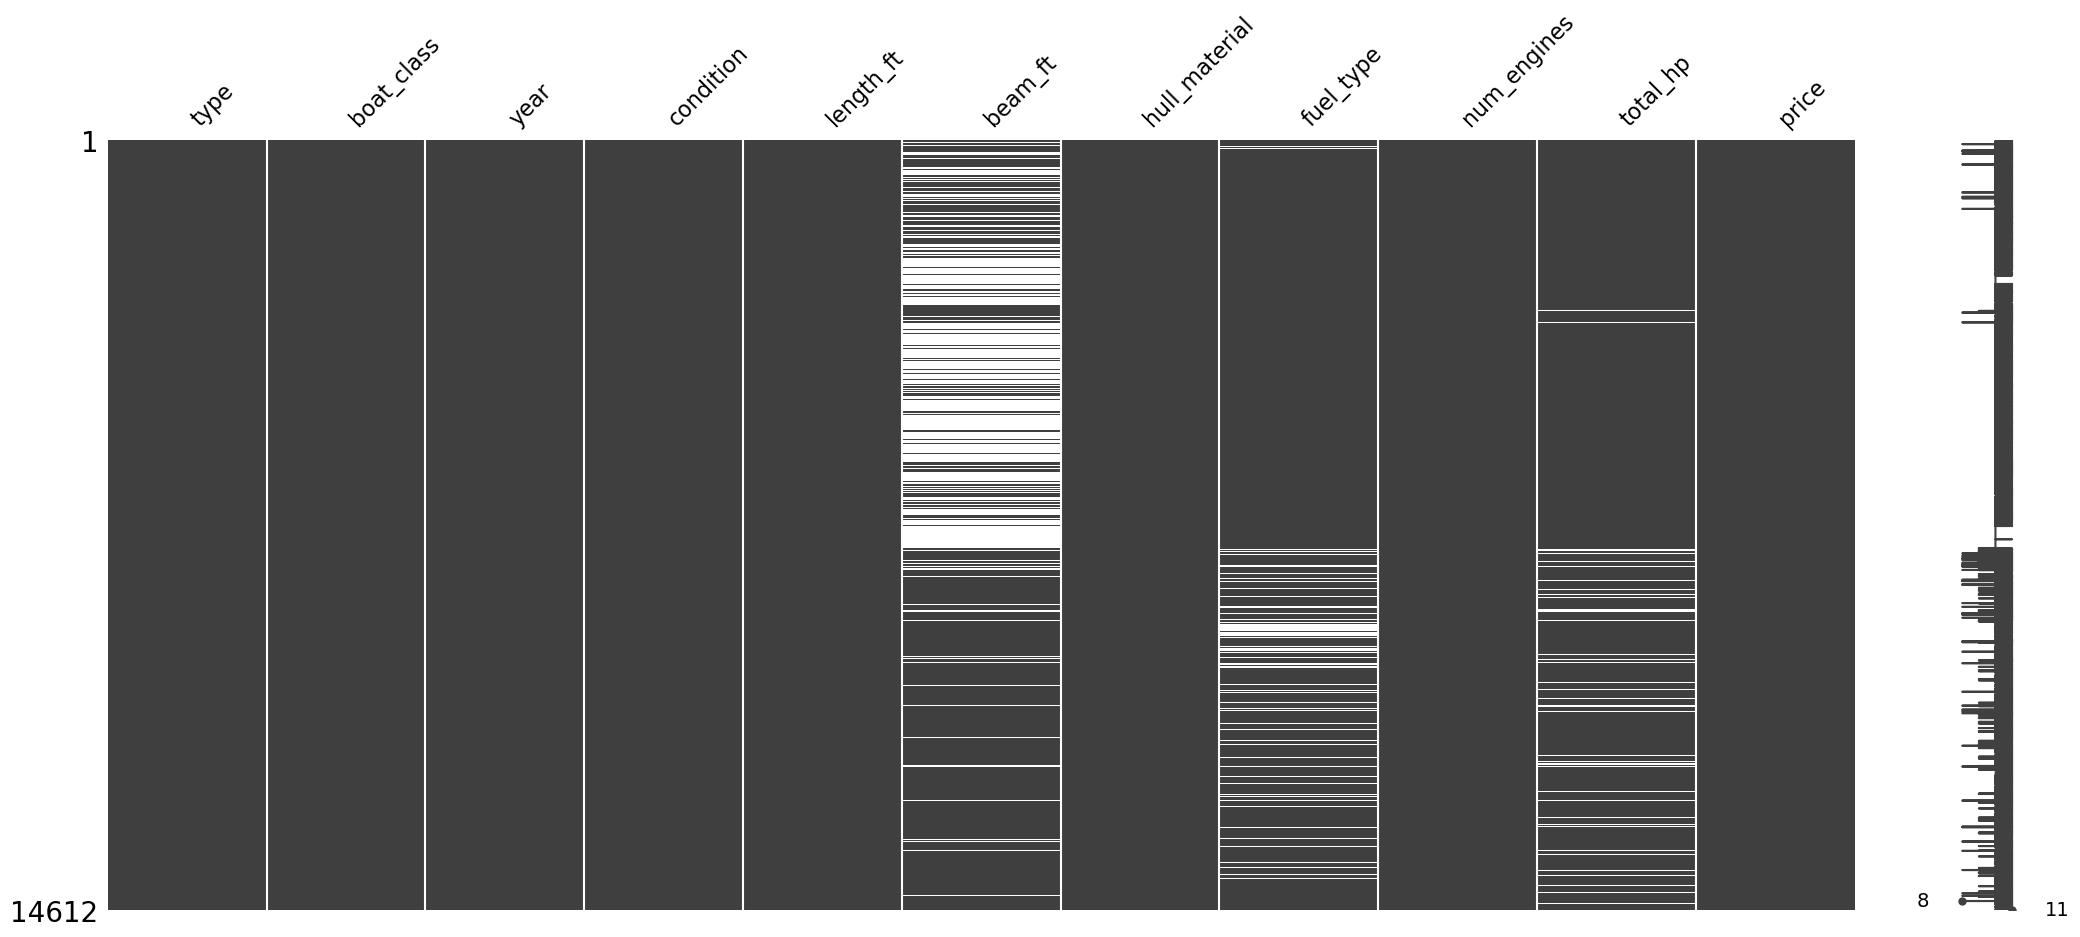

In [100]:
# Observing nulls using missingno library
msno.matrix(df)
plt.show()

In [101]:
# Setting total_hp null records to 0, since the records having 0 engines' total_hp were filled null
df["total_hp"].fillna(0,inplace=True)

In [102]:
# Filling nulls according to their corresponding categorics
data_prep.fill_nulls(df)

In [103]:
# Checking
df.isna().sum().any()

False

## Outlier Handling

In [104]:
# Showing # of outliers and replacing outliers 
for col in num_cols:
    if data_prep.check_outliers(df,col):
        print(f"{col.upper()}")
        print(f"# of outliers: {len(data_prep.get_outliers(df,col))}\n")
        data_prep.replace_outliers(df,col)

YEAR
# of outliers: 9

LENGTH_FT
# of outliers: 85

BEAM_FT
# of outliers: 6

TOTAL_HP
# of outliers: 101

PRICE
# of outliers: 257


# Feature Extraction

In [105]:
# Feature extraction pipeline
df = feat_eng.feat_extract(df)

In [106]:
# Grabbing columns and showing results after feature extraction
num_cols, cat_cols = eda.grab_cols(df,True)

************************* SUMMARY **************************
# of categoric variables: 5
['type', 'condition', 'hull_material', 'fuel_type', 'class']
# of numeric variables: 9
['length_ft', 'beam_ft', 'num_engines', 'total_hp', 'price', 'length_beam', 'hp_per_lb', 'hp_per_engine', 'boat_age']


# Encoding

## Rare Encoding

In [107]:
feat_eng.rare_encoding(df,"hull_material",0.2,"other")
feat_eng.rare_encoding(df,"class",0.04,"other")
feat_eng.rare_encoding(df,"type",0.5,"unpowered")

## One Hot Encoding 

In [108]:
# OHE for categoric variables, I could use label encoding/mapping as Yunus Emre Gündoğmuş preferred.
df = pd.get_dummies(df,columns=cat_cols,drop_first=True,dtype="int")

In [109]:
# Final dataframe
df.head()

,length_ft,beam_ft,num_engines,total_hp,price,length_beam,hp_per_lb,hp_per_engine,boat_age,type_unpowered,condition_used,hull_material_fiberglass,hull_material_other,fuel_type_electric,fuel_type_gasoline,fuel_type_other,class_bass,class_bowrider,class_center,class_cruiser,class_other,class_pontoon,class_skiwake
1,21.000,8.500,1,150.000,16500.000,178.500,0.840,150.000,33,0,1,1,0,0,1,0,0,0,1,0,0,0,0
3,40.000,11.000,2,800.000,491749.000,440.000,1.818,400.000,7,0,1,1,0,0,0,0,0,0,0,0,1,0,0
5,18.000,7.420,1,75.000,26995.000,133.560,0.562,75.000,5,0,0,1,0,0,1,0,0,0,0,0,1,0,0
6,32.000,10.330,2,600.000,169995.000,330.560,1.815,300.000,10,0,1,1,0,0,1,0,0,0,0,0,1,0,0
8,44.000,15.000,2,700.000,109900.000,660.000,1.061,350.000,31,0,1,1,0,0,0,0,0,0,0,0,1,0,0


# Model Preparation

In [110]:
# Splitting features and target
X = df.drop("price",axis=1)
Y = df["price"]

## Feature Selection

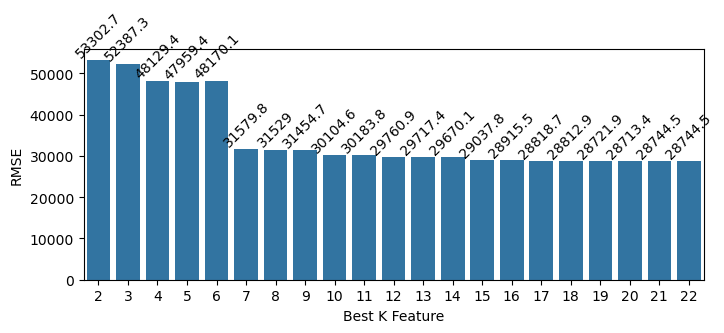

In [111]:
# Feature selection plot
feat_eng.feat_select(X,Y,2,X.shape[1])

In [112]:
# I prefer 10 features and fitting X and Y again
feat_selector = SelectKBest(mutual_info_regression,k=10)
feat_selector.fit(X,Y);

In [113]:
# Selected features
selected_feats = X.columns[feat_selector.get_support()]
selected_feats

Index(['length_ft', 'beam_ft', 'num_engines', 'total_hp', 'length_beam', 'hp_per_lb', 'hp_per_engine', 'boat_age', 'condition_used', 'hull_material_fiberglass'], dtype='object')

In [114]:
# Diminishing data by capturing selected features
X = X.loc[:,selected_feats]

## Train-Val-Test Split

I split my data as train (~70%), validation (~15%) and test (~20%). Validation for hyperparameter tuning and test for evaluating our metric root mean squared error (rmse).

In [115]:
# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [116]:
# Train-Val split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.15)

In [117]:
# Showing # of records for each split
print(f"# of train samples {x_train.shape[0]}")
print(f"# of validation samples {x_val.shape[0]}")
print(f"# of test samples {x_test.shape[0]}")

# of train samples 9935
# of validation samples 1754
# of test samples 2923


## Hyperparameter Tuning

For HT, I used Optuna library. To use optuna, we need to define an objective function. In this case, we are trying to minimize rmse. [Optuna docs](https://optuna.readthedocs.io/en/stable/reference/optuna.html)

In [118]:
def objective(trial:optuna.trial.Trial):
    # Determining parameters and their intervals arbitrarily.
    params = {"max_depth": trial.suggest_int("max_depth",10,25),
              "learning_rate": trial.suggest_float("learning_rate",0.05,0.2),
              "n_estimators": trial.suggest_int("n_estimators",300,1000),
              "objective": trial.suggest_categorical("objective",["huber","regression"])}
    
    # Initialize model and cross validate
    model = LGBMRegressor(verbosity=-1,**params)
    score = np.mean(cross_val_score(model,x_val,y_val,scoring="neg_mean_squared_error",cv=3,verbose=0,n_jobs=-1))
    
    return np.sqrt(-score)

In [119]:
# Create study 
study = optuna.create_study(direction="minimize")

[I 2025-03-12 21:16:32,863] A new study created in memory with name: no-name-65613f47-03d8-4899-9a8a-b75478ed8704


In [120]:
# Start HT with 200 trials
study.optimize(objective,n_trials=200)

[I 2025-03-12 21:16:37,352] Trial 0 finished with value: 37260.01998850904 and parameters: {'max_depth': 18, 'learning_rate': 0.19277680592521607, 'n_estimators': 964, 'objective': 'regression'}. Best is trial 0 with value: 37260.01998850904.
[I 2025-03-12 21:16:39,660] Trial 1 finished with value: 36201.93821072879 and parameters: {'max_depth': 13, 'learning_rate': 0.09021521954925057, 'n_estimators': 374, 'objective': 'regression'}. Best is trial 1 with value: 36201.93821072879.
[I 2025-03-12 21:16:42,721] Trial 2 finished with value: 82862.51727196526 and parameters: {'max_depth': 22, 'learning_rate': 0.18731656585855938, 'n_estimators': 441, 'objective': 'huber'}. Best is trial 1 with value: 36201.93821072879.
[I 2025-03-12 21:16:45,990] Trial 3 finished with value: 37197.575479574785 and parameters: {'max_depth': 25, 'learning_rate': 0.1772451541956797, 'n_estimators': 535, 'objective': 'regression'}. Best is trial 1 with value: 36201.93821072879.
[I 2025-03-12 21:16:49,976] Trial

In [121]:
# Best rmse
study.best_value

35314.574680027814

In [122]:
# Best params
best_params = study.best_params
best_params

{'max_depth': 10,
 'learning_rate': 0.055152963805391086,
 'n_estimators': 451,
 'objective': 'regression'}

In [123]:
# Visualizing history
optuna.visualization.plot_optimization_history(study)

In [124]:
# Visualizing our parameters separately
optuna.visualization.plot_slice(study)

# Training and Saving Model

In [125]:
# Train model with best params
model = LGBMRegressor(verbosity=-1,**best_params)
model.fit(x_train,y_train)

LGBMRegressor(learning_rate=0.055152963805391086, max_depth=10,
              n_estimators=451, objective='regression', verbosity=-1)

In [126]:
# Final rmse score on test set
y_pred = model.predict(x_test)
mean_squared_error(y_test,y_pred,squared=False)

27183.22434704642

In [127]:
# Saving model
pickle.dump(model,open("model.pkl","wb"))